# Requirements

Importing the necessary libraries.

In [16]:
import pandas as pd
import numpy as np

import datetime
import pytz
import requests
from pandas.io.json import json_normalize

import pickle

import os

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.linear_model import LinearRegression

from pyramid.arima import auto_arima

from fbprophet import Prophet

/usr/local/lib/python3.5/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


Some useful functions to support the constructions in this project.

In [2]:
def expand_date_in_dataframe(df):
    """
    It breaks the date attibute (assuming it's a datetime) of a dataframe in more fileds
    for year, month, day, week, day of week, day of year and timestamp.
    """
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['week'] = df.date.dt.week
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['timestamp'] = df.date.values.astype(np.int64)


def str_to_datetime(date):
    """
    Converts a string into a datetime.

    :param str date: The string representation in the format 'yyyy-mm-dd' of the date to convert.
    :return: The resulting datetime.
    :rtype: datetime.datetime
    """
    return datetime.datetime.strptime(date, '%Y-%m-%d')


def datetime_array_to_dataframe(days):
    """
    Gets a dataframe from an array of dates.

    :param list[datetime.datetime] date: The array of dates.
    :return: The dataframe.
    :rtype: pandas.DataFrame
    """
    return pd.DataFrame({'date': days})

# Dataset

In [3]:
class Dataset:
    """
    This class is used to manage the dataset that contains the hsitoric stock prices
    for the companies contemplated in the Dow Jones Industrial Average.
    """

    """ Ticker symbols of the companies contemplated in the  Dow Jones Industrial Average. """
    DJIA_TICKERS = [
        'BA',   'PFE', 'MCD', 'WMT', 'KO',   'MRK',  'HD',   'V',   'JNJ',  'VZ',
        'CSCO', 'AXP', 'TRV', 'DIS', 'MSFT', 'UNH',  'DWDP', 'CAT', 'AAPL', 'UTX',
        'MMM',  'JPM', 'IBM', 'GS',  'XOM',  'INTC', 'NKE',  'CVX', 'PG',   'WBA' ]

    """ Value used to get the historical data from 5 years ago. """
    HIST_5Y = '5y'

    """ Value used to get the historical data from 1 year ago. """
    HIST_1Y = '1y'

    """ Value used to get the historical data from 1 month ago. """
    HIST_1M = '1m'

    """
    This is the template to create the URL to extract historical stock prices
    from the IEX API.
    """
    __IEX_API_URL_TEMPLATE = 'https://api.iextrading.com/1.0/stock/{}/chart/{}'


    def __init__(self, dataframe=None):
        """
        The constructor of Dataset.

        :param pandas.DataFrame df: The dataframe containing stock price historical records,
                                    which will be actual data.
        """
        self.dataframe = dataframe


    @staticmethod
    def __preprocess_dataframe(df):
        """
        Pre-processes a dataframe containing stock price historical records (from IEX)
        by removing the columns that are not useful to make future predictions
        and expanding the date in more columns.

        :param pandas.DataFrame df: The dataframe containing stock price historical records.
        :return: The pre-processed dataframe.
        :rtype: pandas.DataFrame
        """
        formated_df = df.drop(['label',
                               'change', 'changeOverTime', 'changePercent',
                               'high', 'low', 'open',
                               'unadjustedVolume', 'volume', 'vwap'],
                              axis=1)

        expand_date_in_dataframe(formated_df)
        return formated_df


    @staticmethod
    def __get_dataframe_for_ticker(ticker_symbol, hist_period):
        """
        Retrieves the historic prices for a particuler stock from the data source,
        i.e. the IEX API.

        :param str ticker_symbol: The ticker symbol or symbols to filter the data.
        :param str hist_period: The period to retrieve historical records,
                                p.e '5y' for 5 years, '1y' for 1 year, '1m' for 1 month, etc.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """
        # Getting the historic records from IEX
        r = requests.get(url=Dataset.__IEX_API_URL_TEMPLATE.format(ticker_symbol.lower(), hist_period))
        df = json_normalize(r.json())

        # Converting the date to a datetime
        df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

        # Adding the ticker symbol as a new column
        df.insert(loc=0, column='symbol', value=ticker_symbol)

        return Dataset.__preprocess_dataframe(df)


    @staticmethod
    def __get_djia_dataframe(hist_period):
        """
        Gets a dataframe containing historic prices for stocks in the Dow Jones Industrial Average.

        :param str hist_period: The period to retrieve historical records,
                                p.e '5y' for 5 years, '1y' for 1 year, '1m' for 1 month, etc.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """
        df = None

        # Retrieves the historic records for each one of the ticker symbols in the
        # Dow Jones Industrial Average
        for ticker_symbol in Dataset.DJIA_TICKERS:
            if df is None:
                df = Dataset.__get_dataframe_for_ticker(ticker_symbol, hist_period)
            else:
                df = df.append(Dataset.__get_dataframe_for_ticker(ticker_symbol, hist_period))

        return df


    @staticmethod
    def __update_djia_dataframe(df):
        """
        Updates a dataframe containing historic prices for stocks in the Dow Jones Industrial Average,
        by retrieving the most recent records from the information source.

        :param pandas.DataFrame hist_period: The dataframe containing stock price historical records.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """

        # Getting the amount of days that need to be updated
        last_recorded_day = max(df.date)
        today = datetime.datetime.now()
        days_to_update = (today - last_recorded_day).days

        # Deciding the historic period to request to the source according to the days that
        # need to be updated
        hist_period = Dataset.HIST_5Y
        if days_to_update < 1:
            return df
        elif days_to_update < 28:
            hist_period = Dataset.HIST_1M
        elif days_to_update < 365:
            hist_period = Dataset.HIST_1Y

        # Getting the data frame containing the missing records
        last_df = Dataset.__get_djia_dataframe(hist_period)

        # Appending the missing records, dropping the duplicates and returning
        return df.append(last_df).drop_duplicates(['symbol', 'date'], keep='last')


    @staticmethod
    def loadDatasetFromFile(file_name):
        """
        Loads the dataset from a file where data was previously stored.

        :param str file_name: The name of the file to load the data from. 
        """
        with open(file_name, 'rb') as fp:
            return Dataset(pickle.load(fp))


    def saveDataToFile(self, file_name=None):
        """
        Saves the current dataset to a file.

        :param file_name: The name of the file to save the data,
                          if None the data is saved to a file n the 'data' directory
                          using a name of the form 'djia_yyyymmdd-yyyymmdd.pkl'
                          with the minimum and maximum recorded dates. 
        :type file_name: str or None
        """
        if file_name is None:
            file_name = os.path.join(
                'data',
                'djia_{:%Y%m%d}-{:%Y%m%d}.pkl'.format(min(self.dataframe.date), max(self.dataframe.date)))

        with open(file_name, 'wb') as fp:
            pickle.dump(self.dataframe, fp)


    def createData(self, hist_period=HIST_5Y):
        """
        Initializes the dataset with brand new data,
        by default it retrieves historical records from the last 5 years.

        :param str hist_period: The period to retrieve historical records, 5 years ('5y') by default.
        """
        self.dataframe = Dataset.__get_djia_dataframe(hist_period)


    def updateData(self):
        """
        Updates the dataset by getting the most recent history records from the source.
        Note: This method is intended to be run periodicaly in order to keep the dataset up to date.
        """
        self.dataframe = Dataset.__update_djia_dataframe(self.dataframe)


    def getDataframe(self, ticker_symbol=None, from_date=None, to_date=None):
        """
        Gets a dataframe containing a subset of the records of the current dataset,
        which is obtained by filtering by a ticker symbol or list (array) of ticker symbols
        and/or a date range.

        :param ticker_symbol: The ticker symbol or symbols to filter the data.
        :type ticker_symbol: str or list[str] or None
        :param from_date: The minimum date to appear in the records of the subset.
        :type from_date: datetime.datetime or None
        :param to_date: The maximum date to appear in the records of the subset.
        :type to_date: datetime.datetime or None
        :return: The dataframe with the subset resulted of filtering the dataset.
        :rtype: pandas.DataFrame
        """
        df = self.dataframe

        if ticker_symbol is not None:
            if isinstance(ticker_symbol, str): # If ticker_symbol symbol is a string
                df = df.query("symbol == '{}'".format(ticker_symbol))
            elif isinstance(ticker_symbol, list): # If ticker_symbol symbol is an array
                # Creates a query expression as a sequence of ORs
                ticker_symbol_query = None
                for t in ticker_symbol:
                    ticker_symbol_exp = "symbol == '{}'".format(t)
                    if ticker_symbol_query is None:
                        ticker_symbol_query = ticker_symbol_exp
                    else:
                        ticker_symbol_query += "or " + ticker_symbol_exp
                df = df.query(ticker_symbol_query)

        if from_date is not None:
            df = df.query("date >= '{}'".format(from_date))

        if to_date is not None:
            df = df.query("date <= '{}'".format(to_date))

        return df


    
    def getSubset(self, ticker_symbol=None, from_date=None, to_date=None):
        """
        Gets a subset of the current dataset filtered 
        by a ticker symbol or list (array) of ticker symbols and/or a date range.

        :param ticker_symbol: The ticker symbol or symbols to filter the data.
        :type ticker_symbol: str or list[str] or None
        :param from_date: The minimum date to appear in the records of the subset.
        :type from_date: datetime.datetime or None
        :param to_date: The maximum date to appear in the records of the subset.
        :type to_date: datetime.datetime or None
        :return: The subset resulted of filtering the dataset.
        :rtype: Dataset
        """
        df = self.getDataframe(ticker_symbol=ticker_symbol, from_date=from_date, to_date=to_date)
        return Dataset(df)

# Trading days

In [4]:
class TradingDaysHelper:

    def __init__(self, market_holidays_file='market_holidays.txt'):
        self.market_holidays = []

        with open(market_holidays_file) as f:
            lines = f.readlines()

        for line in lines:
            self.market_holidays.append(datetime.datetime.strptime(line.strip(), '%Y-%m-%d'))


    def __is_trading_day(self, day):
        day_of_week = day.weekday()
        if day_of_week == 5 or day_of_week == 6 or day in self.market_holidays:
            return False
        else:
            return True


    def get_trading_days_in_range(self, start_date, end_date):
        trading_days = []

        current_day = start_date
        while (current_day <= end_date):
            if self.__is_trading_day(current_day):
                trading_days.append(current_day)
            current_day += datetime.timedelta(days=1)

        return trading_days

# Models

In [5]:
class StockForecasterModel:
    def __init__(self, ticker_symbol, dataset, trading_days_helper):
        self.ticker_symbol = ticker_symbol
        self.dataset = dataset
        self.trading_days_helper = trading_days_helper

    def train(self, start_date, end_date):
        raise NotImplementedError('Please Implement this method')

    def predict(self, from_date, to_date):
        raise NotImplementedError('Please Implement this method')

In [6]:
class LinearStockForecaster(StockForecasterModel):

    def __init__(self, ticker_symbol, dataset, trading_days_helper):
        StockForecasterModel.__init__(self, ticker_symbol, dataset, trading_days_helper)

    def train(self, start_date=None, end_date=None):
        training_set = self.dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                 from_date=start_date, to_date=end_date)

        x = training_set.drop(['symbol', 'date', 'close'], axis=1)
        y = training_set.close

        self.model = LinearRegression()
        self.model.fit(x, y)

    def predict(self, from_date, to_date):
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(from_date, to_date)

        x = datetime_array_to_dataframe(days_to_predict)
        expand_date_in_dataframe(x)
        x = x.drop(['date'], axis=1)

        y = self.model.predict(x)
        
        return pd.DataFrame({'symbol': self.ticker_symbol, 'date': days_to_predict, 'predicted_price': y})

In [22]:
class ArimaStockForecaster(StockForecasterModel):

    def __init__(self, ticker_symbol, dataset, trading_days_helper):
        StockForecasterModel.__init__(self, ticker_symbol, dataset, trading_days_helper)
        self.training_end = None

    def train(self, start_date=None, end_date=None):
        training_set = self.dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                 from_date=start_date, to_date=end_date)
        self.training_end = max(training_set.date)

        training_set = training_set.close

        self.model = auto_arima(training_set,
                                start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0,
                                seasonal=True, d=1, D=1, trace=True,
                                error_action='ignore', suppress_warnings=True)
        self.model.fit(training_set)

    def predict(self, from_date, to_date):
        if from_date > to_date:
            raise ValueError('Invalid date range to predict')
        if from_date <= self.training_end:
            raise ValueError('Date range to predict should be after last date used for training')

        prediction_start = self.training_end + datetime.timedelta(days=1) 
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(prediction_start, to_date)

        y = self.model.predict(n_periods=days_to_predict.shape[0])
        
        return pd.DataFrame({'symbol': self.ticker_symbol, 'date': days_to_predict, 'predicted_price': y})\
                 .query("date >= '{}' and date <= {}".format(from_date, to_date))


# Analysis

In [7]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [23]:
def measure_performance(results, subplot, model_constructor, total_dataset,
                        ticker_symbol,
                        training_start, training_end,
                        validation_days=[1, 7, 15, 30, 60, 90, 180],
                        simulate_up_to_date_dataset=False):

    validation_start = training_end + datetime.timedelta(days=1)
    max_validation_end = validation_start + datetime.timedelta(days=max(validation_days))
    total_validation_ds = total_dataset.getSubset(ticker_symbol=ticker_symbol,
                                                  from_date=validation_start,
                                                  to_date=max_validation_end)

    training_df = total_dataset.getDataframe(ticker_symbol=ticker_symbol,
                                             from_date=training_start,
                                             to_date=training_end)

    if simulate_up_to_date_dataset:
        dataset = total_dataset.getSubset(ticker_symbol=ticker_symbol,
                                          from_date=training_start,
                                          to_date=max_validation_end)
    else:
        dataset = total_dataset.getSubset(ticker_symbol=ticker_symbol,
                                          from_date=training_start,
                                          to_date=training_end)

    model = model_constructor(ticker_symbol, dataset, trading_days_helper)
    model.train(start_date=training_start, end_date=training_end)

    for v in validation_days:
        validation_end = validation_start + datetime.timedelta(days=v)
        preds = model.predict(validation_start, validation_end)
        validation_df = total_validation_ds.getDataframe(ticker_symbol=ticker_symbol,
                                                         from_date=validation_start,
                                                         to_date=validation_end)

        results.append({'symbol': ticker_symbol,
                        'forecasting_days': v,
                        'RMSE': rmse(preds.predicted_price.values, validation_df.close.values)})

    subplot.plot(training_df.date, training_df.close, label='Training')
    subplot.plot(total_validation_ds.dataframe.date, total_validation_ds.dataframe.close, label='Validation')
    subplot.plot(preds.date, preds.predicted_price, label='Prediction')

    return results

# POCs

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3009.708, BIC=3032.755, Fit time=6.364 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3490.967, BIC=3500.185, Fit time=0.078 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3266.890, BIC=3285.327, Fit time=1.160 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3009.235, BIC=3027.673, Fit time=2.970 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3009.268, BIC=3032.315, Fit time=3.001 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3491.439, BIC=3505.267, Fit time=0.296 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3009.178, BIC=3032.224, Fit time=9.815 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3009.993, BIC=3037.649, Fit time=24.430 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=3007.523, BIC=3025.961, Fit time=5.966 seconds
Fit ARIMA: order=(0, 1, 0) 

TypeError: n_periods must be an int or a long

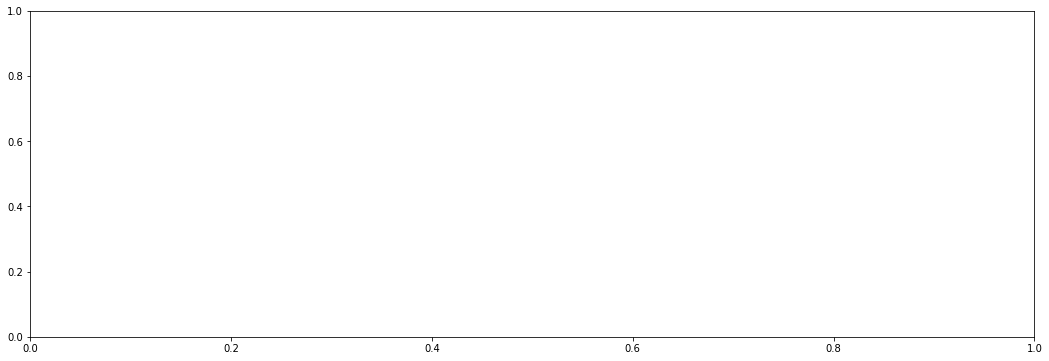

In [24]:
trading_days_helper = TradingDaysHelper()
ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))

training_start = str_to_datetime('2015-04-01')
training_end = str_to_datetime('2018-03-31')

results = []

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(111)

#measure_performance(results, ax1, LinearStockForecaster, ds, 'AAPL', training_start, training_end)
measure_performance(results, ax1, ArimaStockForecaster, ds, 'AAPL', training_start, training_end)
plt.show()

results_df = pd.DataFrame(columns = ['symbol', 'forecasting_days', 'RMSE'], data = results)
print(results_df)

In [ ]:
ds = Dataset()
ds.loaDataFromFile('data/djia_20140303-20190315.pkl')
df = ds.getDataframe(ticker_symbol='AAPL', from_date=str_to_datetime('2015-04-01'), to_date=str_to_datetime('2018-03-31'))
plt.plot(df.date, df.close, label='Dates')

In [ ]:
ds = Dataset()
ds.loaDataFromFile('data/djia_20140303-20190315.pkl')
#ds.createData(hist_period=Dataset.HIST_1Y)
#ds.createData()

df = ds.getDataframe()
print('{} --> {}'.format(min(df.date), max(df.date)))

ds.updateData()
df = ds.getDataframe()
print('{} --> {}'.format(min(df.date), max(df.date)))

ds.saveDataToFile()

In [ ]:
perform_test(djia_ds, 'AAPL', LinearStockForecaster,
             str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))

In [ ]:
h = TradingDaysHelper()
days = h.get_trading_days_in_range(TradingDaysHelper.str_to_datetime('2019-04-01'), TradingDaysHelper.str_to_datetime('2019-04-30'))

print(days)

In [ ]:
ds = Dataset()
ds.loaDataFromFile('data/djia_20140303-20190315.pkl')
trading_days_helper = TradingDaysHelper()

m = LinearStockForecaster('AAPL', ds, trading_days_helper)
m.train(str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))
preds = m.predict(str_to_datetime('2018-04-01'), str_to_datetime('2018-06-30'))

training_set = ds.getDataframe('AAPL', str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))
validation_set = ds.getDataframe('AAPL', str_to_datetime('2018-04-01'), str_to_datetime('2018-06-30'))

plt.plot(training_set.date, training_set.close, label='Training')
plt.plot(validation_set.date, validation_set.close, label='Validation')
plt.plot(preds.date, preds.predicted_price, label='Prediction')

print(preds)

In [ ]:
ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))
trading_days_helper = TradingDaysHelper()
#print(ds.dataframe)

#ts = ds.getSubset(str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))
#tdf = ts.getDataframe()
#print('{} --> {}'.format(min(tdf.date), max(tdf.date)))

tds = ds.getSubset(ticker_symbol=['AAPL', 'IBM', 'MSFT'], from_date=str_to_datetime('2019-03-01'), to_date=str_to_datetime('2019-03-10'))
print(tds.dataframe)

In [ ]:
trading_days_helper = TradingDaysHelper()

ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))
training_ds = ds.getSubset(ticker_symbol='AAPL',
                           from_date=str_to_datetime('2015-04-01'),
                           to_date=str_to_datetime('2018-03-31'))
validation_ds = ds.getSubset(ticker_symbol='AAPL',
                             from_date=str_to_datetime('2018-04-01'),
                             to_date=str_to_datetime('2018-06-30'))

m = LinearStockForecaster('AAPL', training_ds, trading_days_helper)
m.train()
preds = m.predict(str_to_datetime('2018-04-01'), str_to_datetime('2018-06-30'))

plt.plot(training_ds.dataframe.date, training_ds.dataframe.close, label='Training')
plt.plot(validation_ds.dataframe.date, validation_ds.dataframe.close, label='Validation')
plt.plot(preds.date, preds.predicted_price, label='Prediction')

print(preds)